In [ ]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install whoosh
!pip install pytrec_eval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [134]:
import os
import re
from pathlib import Path
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.exceptions import ConvergenceWarning
import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import random
import wget
random.seed()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Please add necessary imports here
import nltk
from nltk.stem import *
from whoosh import index, writing
from whoosh.fields import Schema, TEXT, KEYWORD, ID, STORED
from whoosh.analysis import *
from whoosh.qparser import QueryParser
import os.path
from pathlib import Path
import tempfile
import subprocess
import pytrec_eval
import wget

In [ ]:
# download required resources
nltk.download("wordnet")
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
filename = wget.download("https://github.com/MIE451-2021/course-datasets/raw/main/20_newsgroups.zip", "20_newsgroups.zip")
!unzip 20_newsgroups.zip
DATA_DIR = "20_newsgroups"

Archive:  20_newsgroups.zip
replace 20_newsgroups/talk.politics.mideast/75895? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Functions from lab

**PLEASE DO NOT CHANGE FUNCTION/CLASS NAMES**

**PLEASE DO NOT CHANGE/OVERWRITE COMPLETED FUNCTIONS**

In [ ]:
def clean_file_text(text):
    new_text = re.sub("Newsgroups:.*?\n", "", text)
    new_text = re.sub("Xref:.*?\n", "", new_text)
    new_text = re.sub("Path:.*?\n", "", new_text)
    new_text = re.sub("Date:.*?\n", "", new_text)
    new_text = re.sub("Followup-To:.*?\n", "", new_text)
    return new_text

In [ ]:
def corpus_count_words(file_list):
    tokenizer = RegexpTokenizer(r'\w+')
    word_counter = Counter()
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            file_words = tokenizer.tokenize(file_data)
            word_counter.update(file_words)
    return word_counter

In [ ]:
def get_topic_name(file_path):
    return file_path.parent.name

def get_target(topic_name):
    topics = ['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 
     'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 
     'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics',
     'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc']
    return topics.index(topic_name)

In [ ]:
def plot_confusion_matrix(cm):
    # plot the confusion matrix
    plt.figure(figsize=(10,10))
    plt.matshow(cm, fignum=1)
    
    # add labels for all targets
    num_targets = cm.shape[0]
    plt.xticks(list(range(num_targets+1)))
    plt.yticks(list(range(num_targets+1)))

In [ ]:
from whoosh.analysis import Filter
class CustomFilter(Filter):
    is_morph = True
    def __init__(self, filterFunc, *args, **kwargs):
        self.customFilter = filterFunc
        self.args = args
        self.kwargs = kwargs
    def __eq__(self):
        return (other
                and self.__class__ is other.__class__)
    def __call__(self, tokens):
        for t in tokens:
            if t.mode == 'query': # if called by query parser
                t.text = self.customFilter(t.text, *self.args, **self.kwargs)
                yield t
            else: # == 'index' if called by indexer
                t.text = self.customFilter(t.text, *self.args, **self.kwargs)
                yield t

In [ ]:
def corpus_count_words_V2(file_list):
  
  word_counter = Counter()
  for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            file_data = file.read()
            file_data = clean_file_text(file_data)
            # Use several techniques to improve the text analyzing performance
            NewAnalyzer = RegexTokenizer(r'\w+') | LowercaseFilter()| StopFilter() | StemFilter()|CustomFilter(WordNetLemmatizer().lemmatize)
            file_words = [token.text for token in NewAnalyzer(file_data)]
            word_counter.update(file_words)
  return word_counter

## Q1

In [ ]:
class MLQ1():
    def binary_baseline_data(self, file_list, num_words=1000):
        # Calculate word count in corpus
        news_cnt = corpus_count_words(file_list)

        # Select the most common numWords
        word_list = [word for (word, freq) in news_cnt.most_common(num_words)]

        # Create a binary encoding of dataset based on the selected features (X)
        tokenizer = RegexpTokenizer(r'\w+')
        df_rows = []
        for file_path in file_list:
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                file_data = file.read()
                file_data = clean_file_text(file_data)
                file_words = tokenizer.tokenize(file_data)
                df_rows.append([1 if word in file_words else 0 for word in word_list])
        X = pd.DataFrame(df_rows, index=[str(f) for f in file_list], columns = word_list)

        # Create a dataframe of targets (y)
        y = [get_target(get_topic_name(file_path)) for file_path in file_list]

        return X, y
        

    def binary_improved_data(self, file_list, num_words=1000):
        # Put your code here for Q1b
        # Make sure you update the variable features and targets below
        # Calculate word count in corpus
        news_cnt = corpus_count_words_V2(file_list)
    
        # Select the most common numWords
        word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
        tokenizer = RegexpTokenizer(r'\w+')
        df_rows = []
        for file_path in file_list:
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                file_data = file.read()
                file_data = clean_file_text(file_data)
                # Use several techniques to improve the text analyzing performance
                NewAnalyzer = RegexTokenizer(r'\w+') | LowercaseFilter()| StopFilter() | StemFilter()| CustomFilter(WordNetLemmatizer().lemmatize)
                file_words = [token.text for token in NewAnalyzer(file_data)]
                df_rows.append([1 if word in file_words else 0 for word in word_list])
        X = pd.DataFrame(df_rows, columns = word_list)
        y = [get_target(get_topic_name(file_path)) for file_path in file_list]

        # Please remember to put index for your dataframe as the file name
        # For example: pd.DataFrame(data, index=[str(f) for f in file_list],columns=[])

        # validate return types
        assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"

        return X, y

    def train_and_predict_baseline(self, file_list):
        # get the baseline data
        X, y = self.binary_baseline_data(file_list)

        # split to train and test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # train a logistic regression classifier
        clf = LogisticRegression(C=1.0).fit(X_train, y_train)

        # predict on train and test set
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)

        # calculate train and test accuracy
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)

        return X, y, train_accuracy, test_accuracy

    def train_and_predict_improved(self, file_list):
        # get the baseline data
        X, y = self.binary_improved_data(file_list)

        # Write your code here for Q1c:
        # You need to split the data and train a logistic regression classifier.
        # Then, you need to calculate the variables train_accuracy and test_accuracy for the new classifier
                # split to train and test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # train a logistic regression classifier
        clf = LogisticRegression(C=1.0).fit(X_train, y_train)

        # predict on train and test set
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)

        # calculate train and test accuracy
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)

        return X, y, train_accuracy, test_accuracy

    @staticmethod
    def random_mean_ci(X, y, num_tests):
        # train_results is a list of train accuracy results for the differrent random splits of the dataset
        train_results = []

        # test_results is a list of test accuracy results for the differrent random splits of the dataset
        test_results = []

        # Write your code here for Q1d
        for i in range(num_tests):
          X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))
      
          clf = LogisticRegression(C=1.0).fit(X_train,y_train)

          y_train_predict = clf.predict(X_train)
          y_test_predict = clf.predict(X_test)

          train_accuracy = accuracy_score(y_train,y_train_predict)
          test_accuracy = accuracy_score(y_test,y_test_predict)

          train_results.append(train_accuracy)
          test_results.append(test_accuracy)
        # calculate the train mean and the 95% confidence interval for the list of results
        train_mean = np.mean(train_results)
        train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))

        # calculate the test mean and the 95% confidence interval for the list of results
        test_mean = np.mean(test_results)
        test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))

        # validate return types
        assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
        assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"

        return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high

    @staticmethod
    def random_cm(X, y, num_tests):
        # cm_list is a list of confusion matrices for the different random splits of the dataset
        cm_list = []

        # Write your code here for Q1f
        for i in range(0,num_tests):
          X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3,random_state = random.randint(1,1000))
          clf = LogisticRegression(C=1.0).fit(X_train,y_train)
          y_test_predict = clf.predict(X_test)
          cm = confusion_matrix(y_test,y_test_predict)
          cm_list.append(cm)
        # sum the confusion matrices and return the combined confusion matrix
        combined_cm = np.array(cm_list).sum(axis=0)

        # validate return type
        assert isinstance(combined_cm, np.ndarray), "return type"

        return combined_cm



Please do not change this global variable

In [ ]:
all_files = [pth for pth in Path(DATA_DIR).glob("**/*") if pth.is_file() and not pth.name.startswith(".")]

In [ ]:
q1 = MLQ1()
X, y, train_accuracy, test_accuracy = q1.train_and_predict_baseline(all_files)
# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 0.9432021147388726
Test accuracy: 0.6865


### Q1 (a)

[The feature set consists of the 1000 most commonly occurring words in the file, and each file is represented by a binary value of 1 or 0 for each feature. If a word appears in a file, its corresponding feature value is 1, otherwise it is 0. The dataset contains approximately 19997 samples, which are the number of files in the dataset. The hyperparameter C is set to 1, which is the inverse of the regularization strength. Regularization is a technique that penalizes large parameter values to prevent overfitting. In this case, a small value of C (C=1) is used, which increases the strength of regularization and helps to prevent overfitting.]

In [ ]:
X

,the,to,of,a,and,I,is,in,that,AX,...,friend,HP,isc,present,shall,outside,cars,weapons,recently,Summary
20_newsgroups/alt.atheism/51212,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
20_newsgroups/alt.atheism/53460,1,1,1,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
20_newsgroups/alt.atheism/53096,1,1,1,1,1,1,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0
20_newsgroups/alt.atheism/53338,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
20_newsgroups/alt.atheism/53381,1,1,1,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20_newsgroups/sci.crypt/15194,1,1,1,0,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
20_newsgroups/sci.crypt/15885,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
20_newsgroups/sci.crypt/15407,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
20_newsgroups/sci.crypt/15443,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


### Q1 (b)

Implement *binary_improved_data*

In [56]:
q1 = MLQ1()
X, y = q1.binary_improved_data(all_files)
X

,edu,ax,com,wa,but,thei,line,new,messag,subject,...,archiv,abort,launch,worth,bring,du,shall,iastat,technic,famili
0,1,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,1,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,0,0
4,1,0,1,0,0,1,1,1,1,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19992,0,0,1,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
19993,0,0,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,1,0
19994,1,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
19995,1,0,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


### Q1 (c)

Implement *train_and_predict_improved*

In [ ]:
X, y, train_accuracy, test_accuracy = q1.train_and_predict_improved(all_files)
# report results
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))


Train accuracy: 0.9609916410659427
Test accuracy: 0.7248333333333333


[The results indicate an enhancement in both the training and testing tests. The improvement is attributed to the implementation of lemmatization, stemming, and stop words techniques in the analyzer. These techniques effectively eliminate irrelevant words and prioritize meaningful words.]

### Q1 (d)

Implement *random_mean_ci*


### Q1 (e)

Use the following code to calculate the mean accuracy and 95% confidence interval over 10 random splits

In [ ]:
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = MLQ1.random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.9619989997856683
Train confidence interval over 10 random splits: [0.960958703793811, 0.9630392957775256]
Test mean accuracy over 10 random splits: 0.7228666666666667
Test confidence interval over 10 random splits: [0.719753669048378, 0.7259796642849553]


[ The results presented above indicate that the model's performance has minimal variance for both the training and testing datasets, even when using different data splits. This approach is preferable to running a single trial as it provides the user with an understanding of the model's performance variability.]

### Q1 (f)

Implement *random_cm*


### Q1 (g)

Use the following code to produce a confusion matrix for 10 random splits

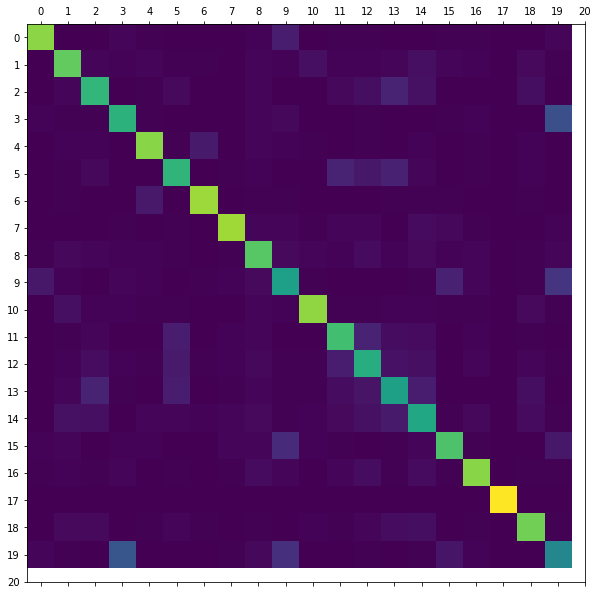

In [ ]:
cm10 = MLQ1.random_cm(X, y, num_tests = 10)
plot_confusion_matrix(cm10)

In [ ]:
# check the actual matrix
pd.DataFrame(cm10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2478,10,5,45,20,7,6,6,24,244,6,13,12,3,8,19,12,0,2,40
1,7,2270,56,26,56,18,14,8,54,28,124,24,34,56,121,42,28,0,81,21
2,2,57,1988,3,12,72,3,10,42,4,11,67,116,300,135,3,8,0,113,4
3,32,20,12,1930,21,1,7,10,45,62,11,6,21,4,1,23,26,0,1,728
4,4,28,32,9,2464,15,218,9,42,28,14,10,13,10,33,11,20,0,30,10
5,1,15,68,4,10,1965,10,19,33,0,9,281,198,275,42,8,19,0,31,10
6,7,21,11,2,210,2,2553,1,18,16,3,9,8,13,19,17,8,0,18,10
7,4,11,7,22,9,19,3,2571,42,53,12,38,48,11,86,59,21,0,8,30
8,23,69,36,32,31,22,7,21,2216,78,45,33,91,26,71,34,45,0,23,51
9,194,32,11,39,24,2,14,24,79,1690,20,2,4,4,21,271,46,4,15,453


[The matrix above reveals that there is a confusion between topic 3 and topic 19. Specifically, for the element (3,19), the value is 799, indicating that the model has predicted 799 instances as topic 3 , when in reality, they belong to topic 19 . Similarly, for the element (19,3), the model has predicted 728 instances as topic 19, when they should have been classified as topic 3. This suggests that the two classes are closely related, making it more challenging to predict correctly. Additionally, since both classes are related to "Talk" and are closely intertwined, this 
leads to further confusion. ]

## Q2

In [ ]:
class MLQ2():
    def feature_num(self, X, y):
        # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
        # where numFeatures is the number of words used as features
        result_list = []

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        for p in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]:
            subset_size = int(p*X.shape[1])
            X_train_subset = X_train.iloc[:, 0:subset_size]
            X_test_subset = X_test.iloc[:, 0:subset_size]
            # Write your code here to calculate train_accuracy and test_accuracy for the current subset of features
            clf = LogisticRegression(C=1.0).fit(X_train_subset,y_train)

            y_train_predict = clf.predict(X_train_subset)
            y_test_predict = clf.predict(X_test_subset)
            train_accuracy = accuracy_score(y_train,y_train_predict)
            test_accuracy = accuracy_score(y_test,y_test_predict)
            # add to result_list
            result_list.append((p, train_accuracy, test_accuracy))

        # Make a dataframe of the results
        result_df = pd.DataFrame(result_list, columns=["num_features", "train_accuracy", "test_accuracy"])

        # validate return type
        assert isinstance(result_df, pd.DataFrame), "return type"

        return result_df

### Q2 (a)

Implement *feature_num*

### Q2 (b)

Use the following code to plot the train and test accuracy for the different feature sets sizes

<AxesSubplot:xlabel='num_features'>

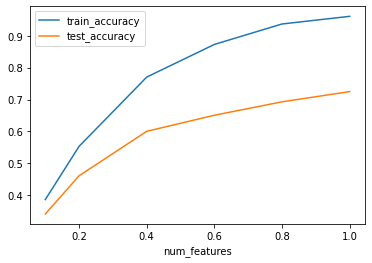

In [ ]:
q2 = MLQ2()
feature_num_df = q2.feature_num(X, y)
feature_num_df.plot(x="num_features", y=["train_accuracy", "test_accuracy"])

[ The performance score increases as the number of features increases.]

## Q3

In [ ]:
class MLQ3():
    def hyperparameter(self, X, y):
        # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
        # where numFeatures is the number of words used as features
        result_list = []

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        for param in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
            # Write your code here to calculate train_accuracy and test_accuracy for the current parameter value
            clf = LogisticRegression(C=param).fit(X_train,y_train)
            y_train_predict = clf.predict(X_train)
            y_test_predict = clf.predict(X_test)
        
            train_accuracy = accuracy_score(y_train,y_train_predict)
            test_accuracy = accuracy_score(y_test,y_test_predict)
            # add to result_list
            result_list.append((param, train_accuracy, test_accuracy))

        # Make a dataframe of the results
        result_df = pd.DataFrame(result_list, columns=["param", "train_accuracy", "test_accuracy"])

        # validate return type
        assert isinstance(result_df, pd.DataFrame), "return type"

        return result_df

### Q3 (a)

Implement *hyperparameter*

### Q3 (b)

Use the following code to plot the train and test accuracy for the different the parameters

<AxesSubplot:xlabel='param'>

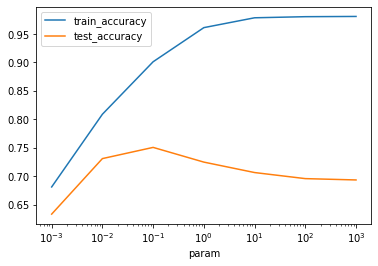

In [ ]:
q3 = MLQ3()
param_df = q3.hyperparameter(X, y)
param_df.plot(x="param", y=["train_accuracy", "test_accuracy"], logx=True)

[ The results indicate that the model achieves the highest performance on the test set when C equals 0.1. When C is less than 0.1, the model is subjected to excessive penalty which can cause underfitting. On the other hand, when C exceeds 0.1, it can result in overfitting. ]

## Q4

In [ ]:
class MLQ4():
    def tf_improved_data(self, file_list, num_words = 1000):
        # Put your code here
        # Make sure you update the variable features and targets below
        # Calculate word count in corpus
        news_cnt = corpus_count_words_V2(file_list)
    
        # Select the most common numWords
        word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
        # Use several techniques to improve the text analyzing performance
        tokenizer = RegexpTokenizer(r'\w+')
        NewAnalyzer = RegexTokenizer(r'\w+') | LowercaseFilter()| StopFilter() | StemFilter()| CustomFilter(WordNetLemmatizer().lemmatize)

        df_rows = []
        word_counter = Counter() # initialize an empty counter
    
        for file_path in file_list:
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                file_data = file.read()
                file_data = clean_file_text(file_data)

                file_words = [token.text for token in NewAnalyzer(file_data)]
    
                word_counter.update(file_words)# Constructed the counter via update() method
            
                df_rows.append([word_counter[word] if word in file_words else 0 for word in word_list]) 
    
        X = pd.DataFrame(df_rows, columns = word_list)
        y = [get_target(get_topic_name(file_path)) for file_path in file_list]

        # validate return types
        assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"

        return X, y


### Q4 (a)

Implement *tf_improved_data*

In [ ]:
X_tf, y_tf = MLQ4().tf_improved_data(all_files)
X_tf

,edu,ax,com,wa,but,thei,line,new,messag,subject,...,archiv,abort,launch,worth,bring,du,shall,iastat,technic,famili
0,7,0,0,0,3,11,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
1,10,0,0,1,4,0,3,4,2,3,...,0,0,0,0,0,0,0,0,0,0
2,14,0,4,2,0,0,4,5,3,4,...,0,0,0,0,0,0,0,0,0,0
3,17,0,8,0,6,15,5,6,5,5,...,0,0,0,0,1,0,0,0,0,0
4,22,0,12,0,0,16,6,7,8,6,...,0,0,0,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19992,0,0,36450,0,0,0,23160,0,22307,22005,...,0,0,0,0,0,0,0,0,0,0
19993,0,0,36460,24550,23259,23201,23162,22868,22309,22006,...,0,0,0,0,776,0,0,0,771,0
19994,66025,0,36464,24552,23261,23202,23163,22869,22310,22007,...,0,0,0,0,0,0,0,0,0,0
19995,66028,0,36468,24554,23263,23206,23164,0,22311,22010,...,0,0,0,0,0,0,0,0,0,0


### Q4 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [ ]:
q4 = MLQ4()
X_tf, y_tf = q4.tf_improved_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = MLQ1.random_mean_ci(X_tf, y_tf, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.7173608630420805
Train confidence interval over 10 random splits: [0.7146099435374488, 0.7201117825467122]
Test mean accuracy over 10 random splits: 0.6546833333333334
Test confidence interval over 10 random splits: [0.6501348387448823, 0.6592318279217845]


[ The performance of TF encoding is observed to be inferior to that of binary coding on this dataset. The primary reason for this is that TF encoding assigns greater importance to words that occur more frequently, while binary encoding assigns equal weight to all words.

Frequency-based encoding methods typically have a tendency to reduce noise and prioritize words that appear less frequently in the text. Additionally, TF encoding is heavily influenced by the specific corpus or dataset that is being used for training. For instance, if the training corpus contains a greater number of entertainment news articles, then the weight assigned to keywords related to entertainment may be lower. Therefore, selecting a high-quality corpus for training is crucial. ]

## Q5

In [ ]:
class MLQ5():
    def nb_random_mean_ci(self, X, y, num_tests):
        # train_results is a list of train accuracy results for the differrent random splits of the dataset
        train_results = []

        # test_results is a list of test accuracy results for the differrent random splits of the dataset
        test_results = []

        # Write your code here
        for i in range(0,num_tests):
          X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))
      
          clf = MultinomialNB().fit(X_train,y_train)# multinomial naive bayes implements the naive bayes algorithm for multinomially distributed data

          y_train_predict = clf.predict(X_train)
          y_test_predict = clf.predict(X_test)

          train_accuracy = accuracy_score(y_train,y_train_predict)
          test_accuracy = accuracy_score(y_test,y_test_predict)

          train_results.append(train_accuracy)
          test_results.append(test_accuracy)
    
        # calculate the train mean and the 95% confidence interval for the list of results
        train_mean = np.mean(train_results)
        train_ci_low, train_ci_high = stats.t.interval(0.95, len(train_results)-1, loc=train_mean, scale=stats.sem(train_results))

        # calculate the test mean and the 95% confidence interval for the list of results
        test_mean = np.mean(test_results)
        test_ci_low, test_ci_high = stats.t.interval(0.95, len(test_results)-1, loc=test_mean, scale=stats.sem(test_results))

        # validate return types
        assert isinstance(train_mean, float) and isinstance(train_ci_low, float) and isinstance(train_ci_high, float), "return types"
        assert isinstance(test_mean, float) and isinstance(test_ci_low, float) and isinstance(test_ci_high, float), "return types"

        return train_mean, train_ci_low, train_ci_high, test_mean, test_ci_low, test_ci_high


### Q5 (a)

Implement *nb_random_mean_ci*


### Q5 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [ ]:
q5 = MLQ5()
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = q5.nb_random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.7690719439879974
Train confidence interval over 10 random splits: [0.7672646785564209, 0.7708792094195739]
Test mean accuracy over 10 random splits: 0.7168166666666667
Test confidence interval over 10 random splits: [0.7149488325803792, 0.7186845007529541]


[ The accuracy results for Naive Bayes on both the training and testing sets have indicated a comparatively lower score than the logistic regression classifier. This may be attributed to the fact that Naive Bayes assumes independence among the features, whereas in our case, the features are generated from the most frequent words in the files, which may not be highly independent from each other. ]

## Q6

In [ ]:
class MLQ6():
    def binary_med_data(self, file_list, num_words = 1000):
        # Put your code here
        # Make sure you update the variable features and targets below
        # Corpus contains the word and its count
        news_cnt = corpus_count_words_V2(file_list)
    
        # Word_list contains the most common numWords
        word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
        # Use several techniques to improve the text analyzing performance
        tokenizer = RegexpTokenizer(r'\w+')
        NewAnalyzer = RegexTokenizer(r'\w+') | LowercaseFilter()| StopFilter() | StemFilter()| CustomFilter(WordNetLemmatizer().lemmatize)
        
        df_rows = []
    
        for file_path in file_list:
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                file_data = file.read()
                file_data = clean_file_text(file_data)
                
                file_words = [token.text for token in NewAnalyzer(file_data)]
                df_rows.append([1 if word in file_words else 0 for word in word_list]) 
    
        X = pd.DataFrame(df_rows, columns = word_list)
        y = [1 if get_topic_name(file_path) == 'sci.med' else 0 for file_path in file_list]# if target name is sci,med returns 1 and retruns 0 for others

        #Please remember to put index for your dataframe as the file name
        #For example: pd.DataFrame(data, index=[str(f) for f in file_list],columns=[])

        # validate return types
        assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"

        return X, y

### Q6 (a)

Implement *binary_med_data*


### Q6 (b)

Use the following code to calculate the mean accuracy and 95% confidence interval over multiple random splits

In [ ]:
q6 = MLQ6()
X, y = q6.binary_med_data(all_files)
train_mean10, train_low10, train_high10, test_mean10, test_low10, test_high10 = MLQ1.random_mean_ci(X, y, num_tests = 10)
print("Train mean accuracy over 10 random splits: {}".format(train_mean10))
print("Train confidence interval over 10 random splits: [{}, {}]".format(train_low10, train_high10))
print("Test mean accuracy over 10 random splits: {}".format(test_mean10))
print("Test confidence interval over 10 random splits: [{}, {}]".format(test_low10, test_high10))

Train mean accuracy over 10 random splits: 0.9910409373437166
Train confidence interval over 10 random splits: [0.9906269951173072, 0.9914548795701259]
Test mean accuracy over 10 random splits: 0.9723166666666667
Test confidence interval over 10 random splits: [0.9707475349618758, 0.9738857983714576]


[ The accuracy results for both the training and testing sets are exceptionally high (both above 97%) for binary classification in Q1, indicating significantly better performance than multiclass classification. However, it is important to note that the dataset suffers from a class imbalance issue where the classes are not equally represented. Therefore, accuracy may not be an appropriate metric to use for evaluating the model's performance as it can be highly misleading.

To gain better insights into the accuracy of the model, I recommend using alternative performance measures such as a confusion matrix, precision (exactness), recall (completeness), and F1 score (a weighted average of precision and recall). These measures can provide a more comprehensive evaluation of the model's performance than traditional classification accuracy. ]

# Q7

## Q7(a)
use the following code cell to implement your feature encoding

In [149]:
def data_q7(file_list, num_words = 3000):
  #write your code here, define your model
  news_cnt = corpus_count_words_V2(file_list)
    
    # Select the most common numWords
  word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
  df_rows = []
  for file_path in file_list:
      with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
          file_data = file.read()
          file_data = clean_file_text(file_data)
          NewAnalyzer = RegexTokenizer(r'\w+') | LowercaseFilter()| StopFilter() | StemFilter()| CustomFilter(WordNetLemmatizer().lemmatize)
          file_words = [token.text for token in NewAnalyzer(file_data)]
          df_rows.append([1 if word in file_words else 0 for word in word_list])
  X = pd.DataFrame(df_rows, index=[str(f) for f in file_list], columns = word_list)
  y = [get_target(get_topic_name(file_path)) for file_path in file_list]
  # validate return types
  assert isinstance(X, pd.DataFrame) and isinstance(y, list), "return types"
  
  return X, y

## Q7(b)
Use the following code cell to implement your model

In [150]:
def build_model_q7():
  #MODELQ7=LogisticRegression(C=0.2)
  #MODELQ7=LogisticRegression(C=0.1, sovler = 'saga')
  #MODELQ7=LogisticRegression(C=0.1, penalty = 'l2')
  #MODELQ7=LogisticRegression(C=0.1)
  #MODELQ7 = MultinomialNB()
  #MODELQ7 = MultinomialNB(alpha=0.5)
  #MODELQ7 = RandomForestClassifier()
  #MODELQ7 = RandomForestClassifier(n_estimators=200)
  MODELQ7 = MultinomialNB()

  return MODELQ7

Code for evaluating p at k

In [151]:
def calculate_average_precision_at_k(MODELQ7, all_files, training_files, testing_files,k=None):
  
  training_files = [str(f) for f in open(training_files,mode='r').read().splitlines()]
  testing_files = [str(f) for f in open(testing_files,mode='r').read().splitlines()]
  if k is None:
    k=len(testing_files)

  X, y = data_q7(all_files) 
  X['gt'] = y
  training = X.loc[training_files]
  X_train = training.loc[:,training.columns!='gt']
  y_train = training['gt'].values

  testing = X.loc[testing_files]
  X_test = testing.loc[:,testing.columns!='gt']
  y_test = testing['gt'].values

  MODELQ7.fit(X_train,y_train)
  y_pred = MODELQ7.predict(X_test)
  y_pred_prob = MODELQ7.predict_proba(X_test)
  confidences = np.max(y_pred_prob,axis=1)
  
  p_at_k = []
  rel_at_k = []
  confidence_order = np.argsort(confidences)
  for i in range(1,k+1):
    top_confidence = confidence_order[-i:]
    pred_top_i = y_pred[top_confidence]
    gt_top_i = np.array(y_test)[top_confidence]
    p_at_i = np.sum(pred_top_i == gt_top_i)/i
    rel_at_i = (pred_top_i[0] == gt_top_i[0])
    p_at_k.append(p_at_i)
    rel_at_k.append(rel_at_i)
  print('average precision at {} is {}'.format(k,np.dot(p_at_k,rel_at_k)/k))
  return np.dot(p_at_k,rel_at_k)/k

In [152]:
# Example usage:
######This line of code must be able to run on Google Colab in under 15 minutes.#####
######Code that runs longer than 15 minutes on the autograder will receive 0 marks for Q7#####
m = calculate_average_precision_at_k(build_model_q7(), all_files, 'training_files_Q7.txt', 'testing_files_Q7.txt')

average precision at 4000 is 0.6656129660065269


# Q7(c)

Best model is 10th try, which uses improved binary encoding, default naive bayes model. The average precision at 4000 is 0.6656129660065269.

1st Try: use 1200 num features(shown in q2 the more the features the better the model accuracy) with binary encoding(shown previously better than tf encoding),try logistic regression(shown previously better than naive bayes model) with hyperparameter c = 0.1(best in q3), the result is:average precision at 4000 is 0.37790170374070203.

2nd Try: use 1200 num featrues with LowercaseFilter()| StopFilter() | StemFilter()| CustomFilter(WordNetLemmatizer().lemmatize) on the features with binary encoding, run the same logistic regression with c=0.1, the result is:average precision at 4000 is 0.5647925450363261. Which is significantly improved. 

3rd Try: try with 1500 num featrues with the rest same as 2nd try, the result is: average precision at 4000 is 0.6060675865694292. Improved again with more num of featrues.

4th Try: tune the hyperparameter c to 0.2, the previous test only test it to be 0.01,0.1 and 1, the best c could any values between 0.01 to 1, with all the rest setting being the same as 3rd try. The result is:average precision at 4000 is 0.600248108419866, slightly lower than 3rd try, but not worth much effort turning hyperparameter c.

5th Try, set the model hyperparameter c back to 0.1, use 1500 num of features and try logistic regression with l2 penalty to avoid overfitting on the training set. The result is: average precision at 4000 is 0.6060675865694292,exactly the same as 3rd one.

6th try, remove the l2 penalty, try a different sovler saga (default is lbfgs), the result is:average precision at 4000 is 0.6057920420817018, slighly lower than lbfgs sovler by default, the change is not significant so it's not worth switching solvers.

7th try, use 2000 num features, improved binary encoding, logistic regression, c = 0.1,it seems that the most useful improvement is the number of features. the result is:average precision at 4000 is 0.6352628122953884. significant improvement.

8th try, use 3000 num featrues, the result is: average precision at 4000 is 0.6624690346825688, AP still improving with increased num features.

9th try, use 1200 num features, try naive bayesion and compare the result with 2nd try. The result is: average precision at 4000 is 0.544194521954847, little lower than 2nd try. 

10th try, use 3000 num features, same naive beys model, the result is:average precision at 4000 is 0.6656129660065269. slightly higher than the 8th best logistic regression model. 

11th try, use 3000 num features, tune Laplace smoothing factor alpha = 0.5(less smoothing),the result is:average precision at 4000 is 0.6650433648940861, slightly lower than 10th try, not worth exploring.

12th try, try 1200 num features with random forest classifier by default, compare result with 2nd try. The result is:average precision at 4000 is 0.5290052814797435, AP lower than 2nd try, still worth exploring.

13th try, try n_estimators=200 with 1200 num features, the result is:average precision at 4000 is 0.5379813041818128, slightly improved.

14th try, try n_estimator = 200 with 3000 num features, the result is: average precision at 4000 is 0.6088514663323488. Not as good as naive bayes or logistic regression.



